Using device: cuda
GPU: Tesla T4
GPU Memory: 14.7 GB
=== StyleGAN Training ===
Initializing StyleGAN...
Starting StyleGAN training for 10 epochs...


Epoch 1/10 - Generator Loss: 0.8373, Discriminator Loss: 0.6266


Epoch 2/10 - Generator Loss: 1.3533, Discriminator Loss: 0.4444


Epoch 3/10 - Generator Loss: 1.8348, Discriminator Loss: 0.3450


Epoch 4/10 - Generator Loss: 2.1018, Discriminator Loss: 0.3119


Epoch 5/10 - Generator Loss: 2.1494, Discriminator Loss: 0.3299


Epoch 6/10 - Generator Loss: 2.1302, Discriminator Loss: 0.3534


Epoch 7/10 - Generator Loss: 2.3167, Discriminator Loss: 0.3301


Epoch 8/10 - Generator Loss: 2.1819, Discriminator Loss: 0.3537


Epoch 9/10 - Generator Loss: 2.4909, Discriminator Loss: 0.3012


Epoch 10/10 - Generator Loss: 2.5461, Discriminator Loss: 0.3016
StyleGAN training completed!

Generating StyleGAN samples...


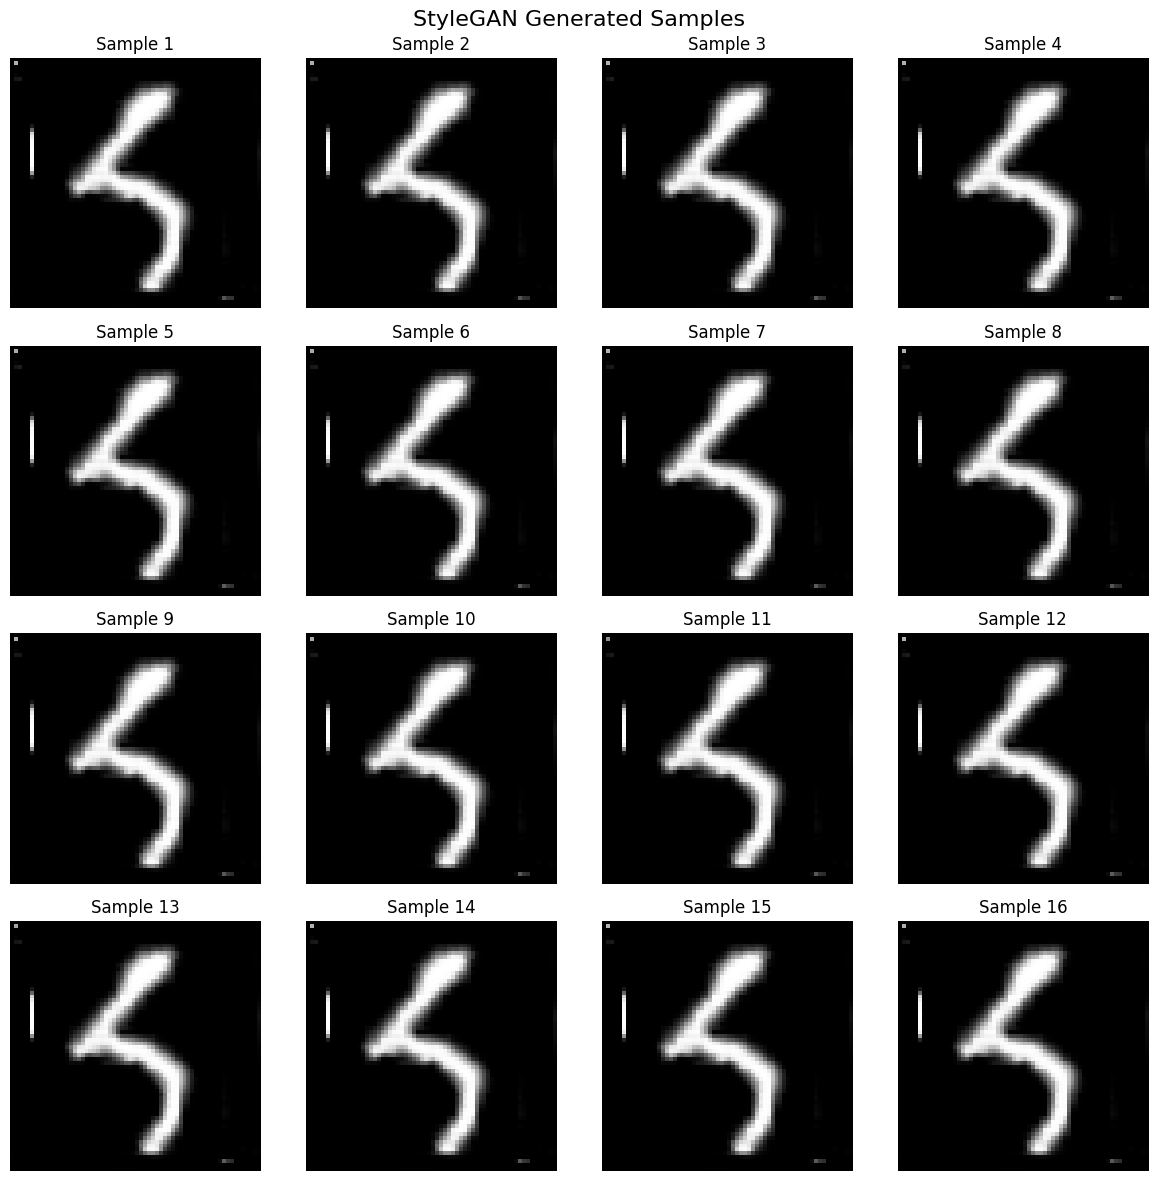

Generating style mixing demonstration...


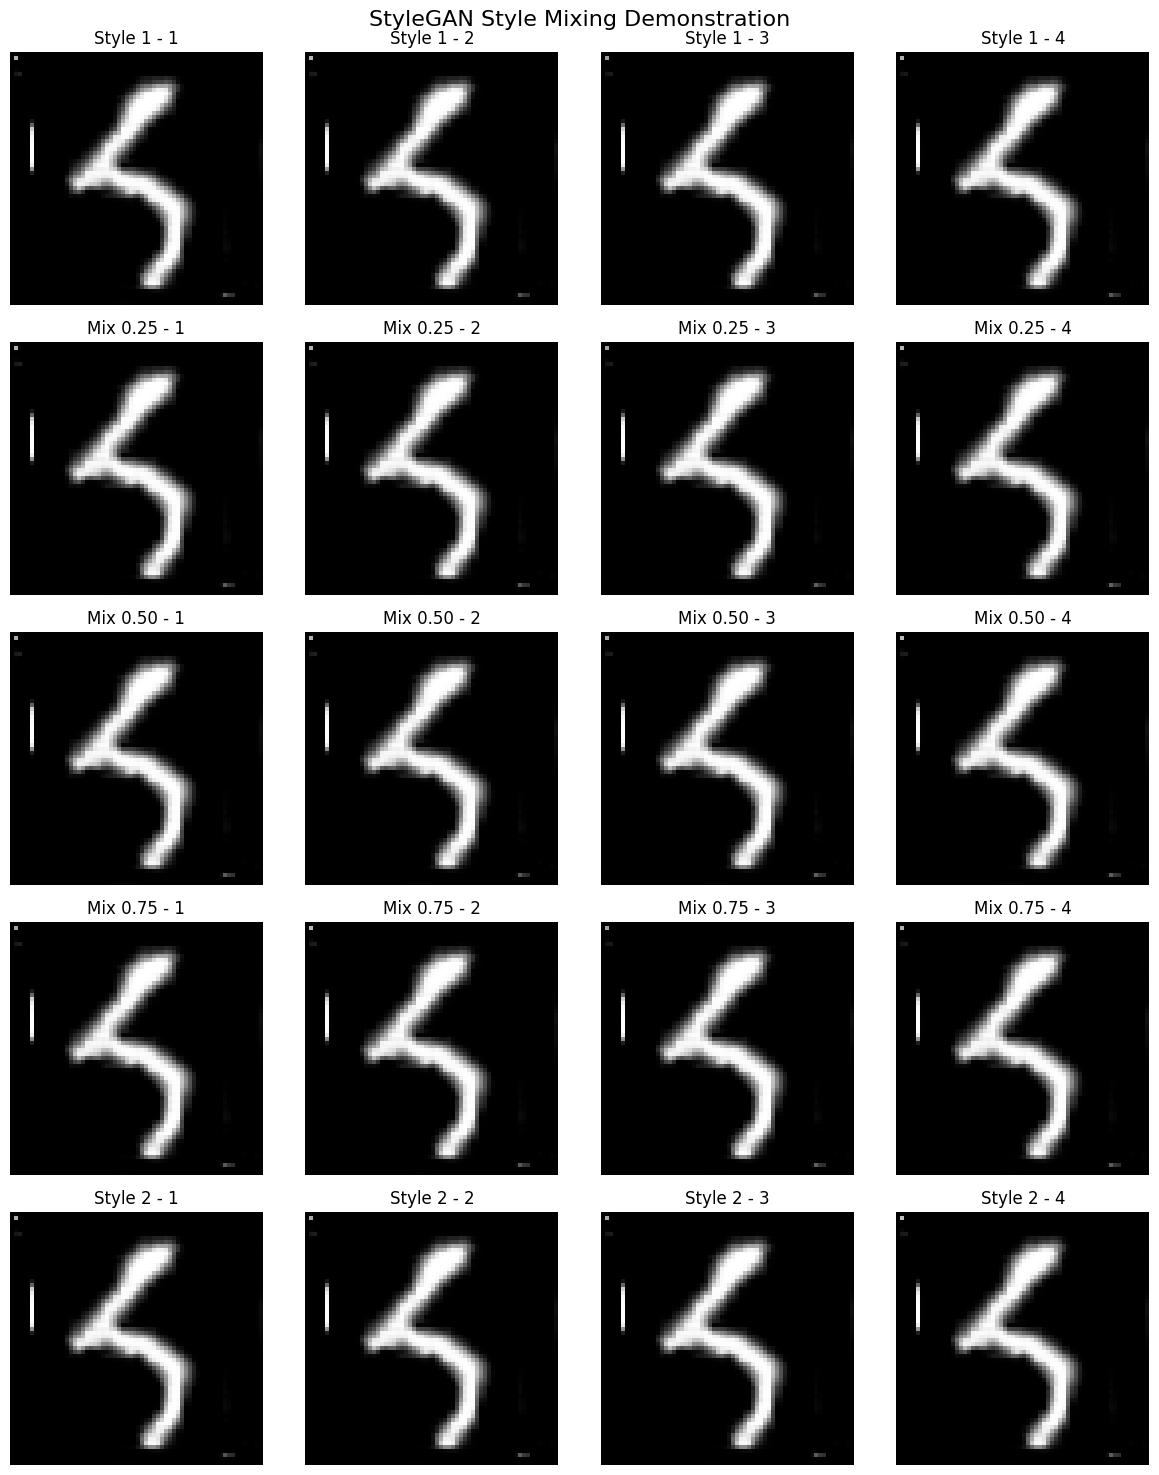

Generating interpolation demonstration...


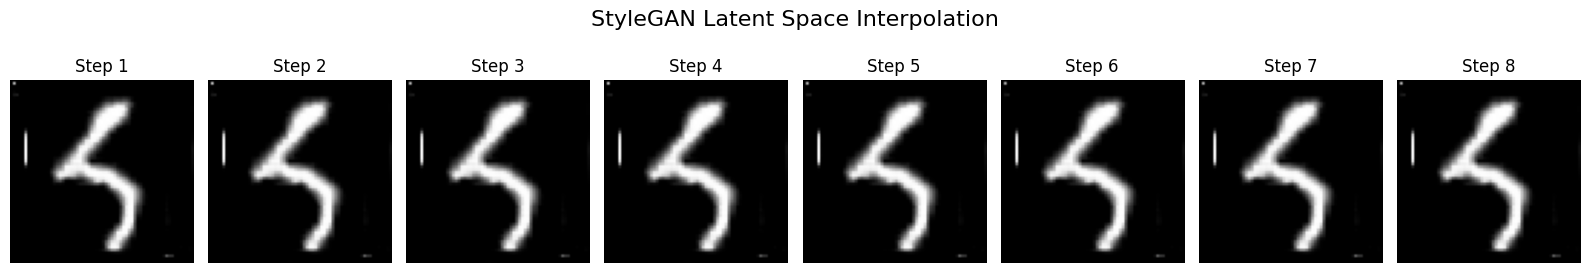

Saving StyleGAN models...
StyleGAN models saved successfully!


In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

class EqualizedLinear(nn.Module):
    """Equalized Linear layer for StyleGAN"""
    def __init__(self, in_dim, out_dim, lr_mul=1.0, bias=True):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_dim, in_dim) / lr_mul)
        self.bias = nn.Parameter(torch.zeros(out_dim)) if bias else None
        self.lr_mul = lr_mul

        # He initialization scaling
        self.w_mul = lr_mul / math.sqrt(in_dim)
        self.b_mul = lr_mul

    def forward(self, x):
        weight = self.weight * self.w_mul
        bias = self.bias
        if bias is not None:
            bias = bias * self.b_mul
        return F.linear(x, weight, bias)

class EqualizedConv2d(nn.Module):
    """Equalized Conv2d layer for StyleGAN"""
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))
        self.bias = nn.Parameter(torch.zeros(out_channels)) if bias else None
        self.stride = stride
        self.padding = padding

        # He initialization scaling
        fan_in = in_channels * kernel_size * kernel_size
        self.w_mul = 1 / math.sqrt(fan_in)

    def forward(self, x):
        weight = self.weight * self.w_mul
        return F.conv2d(x, weight, self.bias, self.stride, self.padding)

class AdaIN(nn.Module):
    """Adaptive Instance Normalization"""
    def __init__(self, channels, w_dim):
        super().__init__()
        self.norm = nn.InstanceNorm2d(channels, affine=False)
        self.style = EqualizedLinear(w_dim, channels * 2, lr_mul=1)

    def forward(self, x, w):
        style = self.style(w).unsqueeze(2).unsqueeze(3)
        gamma, beta = style.chunk(chunks=2, dim=1)
        return gamma * self.norm(x) + beta

class NoiseInjection(nn.Module):
    """Noise injection layer"""
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1, channels, 1, 1))

    def forward(self, x, noise=None):
        if noise is None:
            batch, _, height, width = x.shape
            noise = torch.randn(batch, 1, height, width, device=x.device)
        return x + self.weight * noise

class StyleBlock(nn.Module):
    """Style-based generator block"""
    def __init__(self, in_channels, out_channels, w_dim, upsample=True):
        super().__init__()
        self.upsample = upsample

        self.conv1 = EqualizedConv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = EqualizedConv2d(out_channels, out_channels, 3, padding=1)

        self.noise1 = NoiseInjection(out_channels)
        self.noise2 = NoiseInjection(out_channels)

        self.adain1 = AdaIN(out_channels, w_dim)
        self.adain2 = AdaIN(out_channels, w_dim)

        self.activation = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x, w, noise1=None, noise2=None):
        if self.upsample:
            x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)

        x = self.conv1(x)
        x = self.noise1(x, noise1)
        x = self.activation(x)
        x = self.adain1(x, w)

        x = self.conv2(x)
        x = self.noise2(x, noise2)
        x = self.activation(x)
        x = self.adain2(x, w)

        return x

class MappingNetwork(nn.Module):
    """Mapping network Z -> W"""
    def __init__(self, z_dim=512, w_dim=512, n_layers=8):
        super().__init__()

        layers = []
        for i in range(n_layers):
            layers.append(EqualizedLinear(z_dim if i == 0 else w_dim, w_dim))
            layers.append(nn.LeakyReLU(0.2, inplace=True))

        self.net = nn.Sequential(*layers)

    def forward(self, z):
        return self.net(z)

class SynthesisNetwork(nn.Module):
    """Synthesis network for StyleGAN"""
    def __init__(self, w_dim=512, img_resolution=64, img_channels=3):
        super().__init__()
        self.img_resolution = img_resolution

        # Initial constant input
        self.const_input = nn.Parameter(torch.randn(1, 512, 4, 4))

        # Initial processing
        self.initial_conv = EqualizedConv2d(512, 512, 3, padding=1)
        self.initial_noise = NoiseInjection(512)
        self.initial_adain = AdaIN(512, w_dim)

        # Progressive blocks
        self.blocks = nn.ModuleList()
        self.to_rgbs = nn.ModuleList()

        # Calculate number of blocks needed
        log_resolution = int(math.log2(img_resolution))

        channels = [512, 512, 256, 128, 64, 32][:log_resolution-2]

        for i, ch in enumerate(channels):
            in_ch = 512 if i == 0 else channels[i-1]
            self.blocks.append(StyleBlock(in_ch, ch, w_dim, upsample=True))
            self.to_rgbs.append(EqualizedConv2d(ch, img_channels, 1))

        self.activation = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, w):
        batch_size = w.shape[0]

        # Start with constant input
        x = self.const_input.repeat(batch_size, 1, 1, 1)

        # Initial processing
        x = self.initial_conv(x)
        x = self.initial_noise(x)
        x = self.activation(x)
        x = self.initial_adain(x, w)

        # Progressive upsampling
        for i, (block, to_rgb) in enumerate(zip(self.blocks, self.to_rgbs)):
            x = block(x, w)

            # Check if we've reached target resolution
            if x.shape[-1] >= self.img_resolution:
                break

        # Final RGB conversion
        if self.to_rgbs and len(self.blocks) > 0:
            # Use the to_rgb corresponding to current resolution
            idx = min(i, len(self.to_rgbs) - 1) if 'i' in locals() else len(self.to_rgbs) - 1
            rgb = self.to_rgbs[idx](x)
        else:
            # Fallback
            rgb = EqualizedConv2d(x.shape[1], 3, 1)(x)

        rgb = torch.tanh(rgb)

        # Ensure correct output size
        if rgb.shape[-1] != self.img_resolution:
            rgb = F.interpolate(rgb, size=(self.img_resolution, self.img_resolution), mode='bilinear', align_corners=False)

        return rgb

class StyleGANGenerator(nn.Module):
    """Complete StyleGAN Generator"""
    def __init__(self, z_dim=512, w_dim=512, img_resolution=64, img_channels=3):
        super().__init__()

        self.mapping = MappingNetwork(z_dim, w_dim)
        self.synthesis = SynthesisNetwork(w_dim, img_resolution, img_channels)

    def forward(self, z, truncation_psi=1.0):
        w = self.mapping(z)

        # Truncation trick
        if truncation_psi != 1.0:
            w = truncation_psi * w

        return self.synthesis(w)

class StyleGANDiscriminator(nn.Module):
    """Simplified StyleGAN Discriminator"""
    def __init__(self, img_resolution=64, img_channels=3):
        super().__init__()

        # Progressive discriminator layers
        layers = []

        # Initial layer
        layers.extend([
            EqualizedConv2d(img_channels, 32, 3, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ])

        # Progressive downsampling
        channels = [32, 64, 128, 256, 512]
        for i in range(len(channels) - 1):
            layers.extend([
                EqualizedConv2d(channels[i], channels[i+1], 3, stride=2, padding=1),
                nn.LeakyReLU(0.2, inplace=True)
            ])

        self.conv_layers = nn.Sequential(*layers)

        # Calculate the flattened size after convolutions
        # For 64x64 input with 4 stride-2 convolutions: 64 -> 32 -> 16 -> 8 -> 4 -> 2
        final_size = img_resolution // (2 ** (len(channels) - 1))
        flattened_size = channels[-1] * final_size * final_size

        # Final layers
        self.final_layers = nn.Sequential(
            nn.Flatten(),
            EqualizedLinear(flattened_size, 512),
            nn.LeakyReLU(0.2, inplace=True),
            EqualizedLinear(512, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.final_layers(x)
        return x

def prepare_stylegan_data(batch_size=8, img_size=64):
    """Prepare MNIST data for StyleGAN"""
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    dataset = MNIST(root='./data', train=True, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    return dataloader

def train_stylegan(epochs=80, batch_size=8, lr=0.001, z_dim=512, img_size=64):
    """Train StyleGAN"""
    print("Initializing StyleGAN...")

    # Initialize models
    generator = StyleGANGenerator(z_dim=z_dim, w_dim=z_dim, img_resolution=img_size, img_channels=3).to(device)
    discriminator = StyleGANDiscriminator(img_resolution=img_size, img_channels=3).to(device)

    # Optimizers
    opt_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.0, 0.99))
    opt_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.0, 0.99))

    # Learning rate schedulers
    scheduler_g = optim.lr_scheduler.ExponentialLR(opt_g, gamma=0.99)
    scheduler_d = optim.lr_scheduler.ExponentialLR(opt_d, gamma=0.99)

    # Loss function
    criterion = nn.BCEWithLogitsLoss()

    # Data
    dataloader = prepare_stylegan_data(batch_size, img_size)

    print(f"Starting StyleGAN training for {epochs} epochs...")

    # Fixed noise for generating samples
    fixed_noise = torch.randn(16, z_dim).to(device)

    for epoch in range(epochs):
        epoch_g_loss = 0
        epoch_d_loss = 0
        num_batches = 0

        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)

        for batch_idx, (real_imgs, _) in enumerate(progress_bar):
            current_batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(device, non_blocking=True)

            # Train Discriminator
            opt_d.zero_grad()

            # Real images
            real_validity = discriminator(real_imgs)
            real_labels = torch.ones_like(real_validity)
            d_real_loss = criterion(real_validity, real_labels)

            # Fake images
            noise = torch.randn(current_batch_size, z_dim).to(device)
            fake_imgs = generator(noise)
            fake_validity = discriminator(fake_imgs.detach())
            fake_labels = torch.zeros_like(fake_validity)
            d_fake_loss = criterion(fake_validity, fake_labels)

            d_loss = (d_real_loss + d_fake_loss) / 2
            d_loss.backward()
            opt_d.step()

            # Train Generator
            opt_g.zero_grad()

            gen_validity = discriminator(fake_imgs)
            gen_labels = torch.ones_like(gen_validity)
            g_loss = criterion(gen_validity, gen_labels)

            g_loss.backward()
            opt_g.step()

            # Accumulate losses
            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()
            num_batches += 1

            progress_bar.set_postfix({
                'G_Loss': f'{g_loss.item():.4f}',
                'D_Loss': f'{d_loss.item():.4f}'
            })

            # Generate samples periodically
            if batch_idx == 0 and (epoch + 1) % 15 == 0:
                generate_stylegan_samples(generator, fixed_noise, epoch + 1)

        # Update learning rates
        scheduler_g.step()
        scheduler_d.step()

        # Print epoch statistics
        if num_batches > 0:
            avg_g_loss = epoch_g_loss / num_batches
            avg_d_loss = epoch_d_loss / num_batches
            print(f"Epoch {epoch+1}/{epochs} - Generator Loss: {avg_g_loss:.4f}, Discriminator Loss: {avg_d_loss:.4f}")

    print("StyleGAN training completed!")
    return generator, discriminator

def generate_stylegan_samples(generator, noise, epoch=None, num_samples=16):
    """Generate and display StyleGAN samples"""
    generator.eval()

    with torch.no_grad():
        if noise.size(0) != num_samples:
            noise = noise[:num_samples] if noise.size(0) > num_samples else torch.randn(num_samples, noise.size(1)).to(device)

        generated_imgs = generator(noise)

    # Convert to numpy for visualization
    generated_imgs = (generated_imgs + 1) / 2  # [-1, 1] to [0, 1]
    generated_imgs = generated_imgs.cpu().numpy()
    generated_imgs = np.transpose(generated_imgs, (0, 2, 3, 1))

    # Plot samples
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.flatten()

    for i in range(min(num_samples, 16)):
        img = generated_imgs[i]
        # Convert to grayscale for display
        img_gray = np.mean(img, axis=-1)
        axes[i].imshow(img_gray, cmap='gray')
        axes[i].set_title(f'Sample {i+1}')
        axes[i].axis('off')

    # Hide unused subplots
    for i in range(num_samples, 16):
        axes[i].axis('off')

    title = 'StyleGAN Generated Samples'
    if epoch:
        title += f' - Epoch {epoch}'
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

    generator.train()

def style_mixing_demo(generator, z_dim=512, num_samples=4):
    """Demonstrate style mixing in StyleGAN"""
    generator.eval()

    print("Generating style mixing demonstration...")

    with torch.no_grad():
        # Generate different latent codes
        z1 = torch.randn(num_samples, z_dim).to(device)
        z2 = torch.randn(num_samples, z_dim).to(device)

        # Generate pure samples
        imgs1 = generator(z1)
        imgs2 = generator(z2)

        # Mix styles (simple interpolation)
        mixed_imgs = []
        for alpha in [0.25, 0.5, 0.75]:
            z_mixed = alpha * z1 + (1 - alpha) * z2
            mixed = generator(z_mixed)
            mixed_imgs.append(mixed)

    # Convert to numpy
    def to_numpy(imgs):
        imgs = (imgs + 1) / 2
        imgs = imgs.cpu().numpy()
        return np.transpose(imgs, (0, 2, 3, 1))

    imgs1_np = to_numpy(imgs1)
    imgs2_np = to_numpy(imgs2)
    mixed_np = [to_numpy(mixed) for mixed in mixed_imgs]

    # Plot results
    fig, axes = plt.subplots(5, num_samples, figsize=(12, 15))

    for i in range(num_samples):
        # Original style 1
        img = np.mean(imgs1_np[i], axis=-1)
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f'Style 1 - {i+1}')
        axes[0, i].axis('off')

        # Mixed styles
        for j, mixed in enumerate(mixed_np):
            img = np.mean(mixed[i], axis=-1)
            axes[j+1, i].imshow(img, cmap='gray')
            axes[j+1, i].set_title(f'Mix {(j+1)*0.25:.2f} - {i+1}')
            axes[j+1, i].axis('off')

        # Original style 2
        img = np.mean(imgs2_np[i], axis=-1)
        axes[4, i].imshow(img, cmap='gray')
        axes[4, i].set_title(f'Style 2 - {i+1}')
        axes[4, i].axis('off')

    plt.suptitle('StyleGAN Style Mixing Demonstration', fontsize=16)
    plt.tight_layout()
    plt.show()

    generator.train()

def interpolation_demo(generator, z_dim=512, num_steps=8):
    """Demonstrate latent space interpolation"""
    generator.eval()

    print("Generating interpolation demonstration...")

    with torch.no_grad():
        # Two random points in latent space
        z1 = torch.randn(1, z_dim).to(device)
        z2 = torch.randn(1, z_dim).to(device)

        # Interpolate between them
        interpolated_imgs = []
        for i in range(num_steps):
            alpha = i / (num_steps - 1)
            z_interp = (1 - alpha) * z1 + alpha * z2
            img = generator(z_interp)
            interpolated_imgs.append(img)

    # Convert to numpy
    interpolated_imgs = torch.cat(interpolated_imgs, 0)
    interpolated_imgs = (interpolated_imgs + 1) / 2
    interpolated_imgs = interpolated_imgs.cpu().numpy()
    interpolated_imgs = np.transpose(interpolated_imgs, (0, 2, 3, 1))

    # Plot interpolation
    fig, axes = plt.subplots(1, num_steps, figsize=(16, 3))

    for i in range(num_steps):
        img = np.mean(interpolated_imgs[i], axis=-1)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Step {i+1}')
        axes[i].axis('off')

    plt.suptitle('StyleGAN Latent Space Interpolation', fontsize=16)
    plt.tight_layout()
    plt.show()

    generator.train()

# Run StyleGAN training
if __name__ == "__main__":
    print("=== StyleGAN Training ===")
    stylegan_gen, stylegan_disc = train_stylegan(epochs=10, batch_size=8, lr=0.0002, img_size=64)

    # Generate StyleGAN samples
    print("\nGenerating StyleGAN samples...")
    noise = torch.randn(16, 512).to(device)
    generate_stylegan_samples(stylegan_gen, noise)

    # StyleGAN demonstrations
    style_mixing_demo(stylegan_gen)
    interpolation_demo(stylegan_gen)

    # Save models
    print("Saving StyleGAN models...")
    torch.save(stylegan_gen.state_dict(), 'stylegan_generator.pth')
    torch.save(stylegan_disc.state_dict(), 'stylegan_discriminator.pth')
    print("StyleGAN models saved successfully!")

In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

class EqualizedLinear(nn.Module):
    """Equalized Linear layer for StyleGAN"""
    def __init__(self, in_dim, out_dim, lr_mul=1.0, bias=True):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_dim, in_dim) / lr_mul)
        self.bias = nn.Parameter(torch.zeros(out_dim)) if bias else None
        self.lr_mul = lr_mul

        # He initialization scaling
        self.w_mul = lr_mul / math.sqrt(in_dim)
        self.b_mul = lr_mul

    def forward(self, x):
        weight = self.weight * self.w_mul
        bias = self.bias
        if bias is not None:
            bias = bias * self.b_mul
        return F.linear(x, weight, bias)

class EqualizedConv2d(nn.Module):
    """Equalized Conv2d layer for StyleGAN"""
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))
        self.bias = nn.Parameter(torch.zeros(out_channels)) if bias else None
        self.stride = stride
        self.padding = padding

        # He initialization scaling
        fan_in = in_channels * kernel_size * kernel_size
        self.w_mul = 1 / math.sqrt(fan_in)

    def forward(self, x):
        weight = self.weight * self.w_mul
        return F.conv2d(x, weight, self.bias, self.stride, self.padding)

class AdaIN(nn.Module):
    """Adaptive Instance Normalization"""
    def __init__(self, channels, w_dim):
        super().__init__()
        self.norm = nn.InstanceNorm2d(channels, affine=False)
        self.style = EqualizedLinear(w_dim, channels * 2, lr_mul=1)

    def forward(self, x, w):
        style = self.style(w).unsqueeze(2).unsqueeze(3)
        gamma, beta = style.chunk(chunks=2, dim=1)
        return gamma * self.norm(x) + beta

class NoiseInjection(nn.Module):
    """Noise injection layer"""
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1, channels, 1, 1))

    def forward(self, x, noise=None):
        if noise is None:
            batch, channels, height, width = x.shape
            noise = torch.randn(batch, 1, height, width, device=x.device)
        return x + self.weight * noise

class StyleBlock(nn.Module):
    """Style-based generator block"""
    def __init__(self, in_channels, out_channels, w_dim, upsample=True):
        super().__init__()
        self.upsample = upsample

        if upsample:
            self.conv1 = EqualizedConv2d(in_channels, out_channels, 3, padding=1)
        else:
            self.conv1 = EqualizedConv2d(in_channels, out_channels, 3, padding=1)

        self.conv2 = EqualizedConv2d(out_channels, out_channels, 3, padding=1)

        self.noise1 = NoiseInjection(out_channels)
        self.noise2 = NoiseInjection(out_channels)

        self.adain1 = AdaIN(out_channels, w_dim)
        self.adain2 = AdaIN(out_channels, w_dim)

        self.activation = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x, w, noise1=None, noise2=None):
        if self.upsample:
            x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)

        x = self.conv1(x)
        x = self.noise1(x, noise1)
        x = self.activation(x)
        x = self.adain1(x, w)

        x = self.conv2(x)
        x = self.noise2(x, noise2)
        x = self.activation(x)
        x = self.adain2(x, w)

        return x

class MappingNetwork(nn.Module):
    """Mapping network Z -> W"""
    def __init__(self, z_dim=512, w_dim=512, n_layers=8):
        super().__init__()

        layers = []
        for i in range(n_layers):
            layers.append(EqualizedLinear(z_dim if i == 0 else w_dim, w_dim))
            layers.append(nn.LeakyReLU(0.2, inplace=True))

        self.net = nn.Sequential(*layers)

    def forward(self, z):
        return self.net(z)

class SynthesisNetwork(nn.Module):
    """Synthesis network for StyleGAN"""
    def __init__(self, w_dim=512, img_resolution=128, img_channels=3):
        super().__init__()

        # Initial constant input
        self.const_input = nn.Parameter(torch.randn(1, 512, 4, 4))

        # Initial style block (4x4)
        self.initial_conv = EqualizedConv2d(512, 512, 3, padding=1)
        self.initial_noise = NoiseInjection(512)
        self.initial_adain = AdaIN(512, w_dim)

        # Progressive blocks
        self.blocks = nn.ModuleList()
        self.to_rgbs = nn.ModuleList()

        channels = [512, 512, 512, 256, 128, 64, 32]
        resolutions = [8, 16, 32, 64, 128, 256, 512]

        for i, (res, ch) in enumerate(zip(resolutions, channels)):
            if res <= img_resolution:
                in_ch = 512 if i == 0 else channels[i-1]
                self.blocks.append(StyleBlock(in_ch, ch, w_dim, upsample=True))
                self.to_rgbs.append(EqualizedConv2d(ch, img_channels, 1))

        self.activation = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, w):
        batch_size = w.shape[0]

        # Start with constant input
        x = self.const_input.repeat(batch_size, 1, 1, 1)

        # Initial processing
        x = self.initial_conv(x)
        x = self.initial_noise(x)
        x = self.activation(x)
        x = self.initial_adain(x, w)

        # Progressive upsampling
        for i, (block, to_rgb) in enumerate(zip(self.blocks, self.to_rgbs)):
            x = block(x, w)

        # Final RGB conversion
        if self.to_rgbs:
            rgb = self.to_rgbs[-1](x)
            rgb = torch.tanh(rgb)
        else:
            rgb = torch.tanh(x)

        return rgb

class StyleGANDiscriminator(nn.Module):
    """StyleGAN Discriminator with progressive architecture"""
    def __init__(self, img_resolution=128, img_channels=3):
        super().__init__()

        # From RGB layers
        self.from_rgbs = nn.ModuleList()

        # Progressive blocks
        self.blocks = nn.ModuleList()

        channels = [32, 64, 128, 256, 512, 512, 512]
        resolutions = [128, 64, 32, 16, 8, 4, 4]

        for i, (res, ch) in enumerate(zip(resolutions, channels)):
            if res <= img_resolution:
                # From RGB
                if i == 0:
                    self.from_rgbs.append(EqualizedConv2d(img_channels, ch, 1))
                else:
                    self.from_rgbs.append(EqualizedConv2d(img_channels, ch, 1))

                # Discriminator block
                if i == len(channels) - 1:
                    # Final block
                    self.blocks.append(nn.Sequential(
                        EqualizedConv2d(ch, ch, 3, padding=1),
                        nn.LeakyReLU(0.2, inplace=True),
                        EqualizedConv2d(ch, ch, 2),
                        nn.LeakyReLU(0.2, inplace=True),
                        nn.Flatten(), # Flatten the output before Linear layer
                        EqualizedLinear(ch * 1 * 1, 1) # Adjust input size based on flattened shape
                    ))
                else:
                    out_ch = channels[i + 1]
                    self.blocks.append(nn.Sequential(
                        EqualizedConv2d(ch, ch, 3, padding=1),
                        nn.LeakyReLU(0.2, inplace=True),
                        EqualizedConv2d(ch, out_ch, 3, padding=1),
                        nn.LeakyReLU(0.2, inplace=True),
                        nn.AvgPool2d(2)
                    ))

        self.activation = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        # From RGB
        if self.from_rgbs:
            x = self.from_rgbs[0](x)
            x = self.activation(x)

        # Progressive downsampling
        for block in self.blocks[:-1]:
            x = block(x)

        # Final block
        if self.blocks:
            x = self.blocks[-1](x)
            # Flattening is now handled within the Sequential block
            # if x.dim() > 2:
            #     x = x.view(x.shape[0], -1)

        return x

def prepare_stylegan_data(batch_size=16, img_size=64):
    """Prepare MNIST data for StyleGAN"""
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    dataset = MNIST(root='./data', train=True, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    return dataloader

def compute_gradient_penalty(discriminator, real_data, fake_data, device):
    """Compute gradient penalty for WGAN-GP"""
    batch_size = real_data.size(0)

    # Random interpolation between real and fake data
    alpha = torch.rand(batch_size, 1, 1, 1).to(device)
    interpolated = alpha * real_data + (1 - alpha) * fake_data
    interpolated.requires_grad_(True)

    # Get discriminator output
    d_interpolated = discriminator(interpolated)

    # Compute gradients
    gradients = torch.autograd.grad(
        outputs=d_interpolated,
        inputs=interpolated,
        grad_outputs=torch.ones_like(d_interpolated),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(batch_size, -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    return gradient_penalty

def train_stylegan(epochs=100, batch_size=8, lr=0.001, z_dim=512, img_size=64):
    """Train StyleGAN"""
    print("Initializing StyleGAN...")

    # Initialize models
    generator = StyleGANGenerator(z_dim=z_dim, w_dim=z_dim, img_resolution=img_size, img_channels=3).to(device)
    discriminator = StyleGANDiscriminator(img_resolution=img_size, img_channels=3).to(device)

    # Optimizers
    opt_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.0, 0.99))
    opt_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.0, 0.99))

    # Learning rate schedulers
    scheduler_g = optim.lr_scheduler.ExponentialLR(opt_g, gamma=0.99)
    scheduler_d = optim.lr_scheduler.ExponentialLR(opt_d, gamma=0.99)

    # Loss function
    criterion = nn.BCEWithLogitsLoss()

    # Data
    dataloader = prepare_stylegan_data(batch_size, img_size)

    print(f"Starting StyleGAN training for {epochs} epochs...")

    # Fixed noise for generating samples
    fixed_noise = torch.randn(16, z_dim).to(device)

    for epoch in range(epochs):
        epoch_g_loss = 0
        epoch_d_loss = 0
        num_batches = 0

        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}')

        for batch_idx, (real_imgs, _) in enumerate(progress_bar):
            current_batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(device)

            # Train Discriminator
            opt_d.zero_grad()

            # Real images
            real_validity = discriminator(real_imgs)
            d_real_loss = criterion(real_validity, torch.ones_like(real_validity))

            # Fake images
            noise = torch.randn(current_batch_size, z_dim).to(device)
            fake_imgs = generator(noise)
            fake_validity = discriminator(fake_imgs.detach())
            d_fake_loss = criterion(fake_validity, torch.zeros_like(fake_validity))

            d_loss = (d_real_loss + d_fake_loss) / 2
            d_loss.backward()
            opt_d.step()

            # Train Generator
            opt_g.zero_grad()

            gen_validity = discriminator(fake_imgs)
            g_loss = criterion(gen_validity, torch.ones_like(gen_validity))

            g_loss.backward()
            opt_g.step()

            # Accumulate losses
            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()
            num_batches += 1

            progress_bar.set_postfix({
                'G_Loss': f'{g_loss.item():.4f}',
                'D_Loss': f'{d_loss.item():.4f}'
            })

            # Generate samples periodically
            if batch_idx == 0 and (epoch + 1) % 20 == 0:
                generate_stylegan_samples(generator, fixed_noise, epoch + 1)

        # Update learning rates
        scheduler_g.step()
        scheduler_d.step()

        # Print epoch statistics
        if num_batches > 0:
            avg_g_loss = epoch_g_loss / num_batches
            avg_d_loss = epoch_d_loss / num_batches
            print(f"Epoch {epoch+1} - Generator Loss: {avg_g_loss:.4f}, Discriminator Loss: {avg_d_loss:.4f}")

    print("StyleGAN training completed!")
    return generator, discriminator

def generate_stylegan_samples(generator, noise, epoch=None, num_samples=16):
    """Generate and display StyleGAN samples"""
    generator.eval()

    with torch.no_grad():
        if noise.size(0) != num_samples:
            noise = noise[:num_samples] if noise.size(0) > num_samples else torch.randn(num_samples, noise.size(1)).to(device)

        generated_imgs = generator(noise)

    # Convert to numpy for visualization
    generated_imgs = (generated_imgs + 1) / 2  # [-1, 1] to [0, 1]
    generated_imgs = generated_imgs.cpu().numpy()
    generated_imgs = np.transpose(generated_imgs, (0, 2, 3, 1))

    # Plot samples
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.flatten()

    for i in range(min(num_samples, 16)):
        img = generated_imgs[i]
        # Convert to grayscale for display
        img_gray = np.mean(img, axis=-1)
        axes[i].imshow(img_gray, cmap='gray')
        axes[i].set_title(f'Sample {i+1}')
        axes[i].axis('off')

    # Hide unused subplots
    for i in range(num_samples, 16):
        axes[i].axis('off')

    title = 'StyleGAN Generated Samples'
    if epoch:
        title += f' - Epoch {epoch}'
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

    generator.train()

def style_mixing_demo(generator, z_dim=512, num_samples=4):
    """Demonstrate style mixing in StyleGAN"""
    generator.eval()

    print("Generating style mixing demonstration...")

    with torch.no_grad():
        # Generate different latent codes
        z1 = torch.randn(num_samples, z_dim).to(device)
        z2 = torch.randn(num_samples, z_dim).to(device)

        # Generate pure samples
        imgs1 = generator(z1)
        imgs2 = generator(z2)

        # Mix styles (simple interpolation)
        mixed_imgs = []
        for alpha in [0.25, 0.5, 0.75]:
            z_mixed = alpha * z1 + (1 - alpha) * z2
            mixed = generator(z_mixed)
            mixed_imgs.append(mixed)

    # Convert to numpy
    def to_numpy(imgs):
        imgs = (imgs + 1) / 2
        imgs = imgs.cpu().numpy()
        return np.transpose(imgs, (0, 2, 3, 1))

    imgs1_np = to_numpy(imgs1)
    imgs2_np = to_numpy(imgs2)
    mixed_np = [to_numpy(mixed) for mixed in mixed_imgs]

    # Plot results
    fig, axes = plt.subplots(5, num_samples, figsize=(12, 15))

    for i in range(num_samples):
        # Original style 1
        img = np.mean(imgs1_np[i], axis=-1)
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f'Style 1 - {i+1}')
        axes[0, i].axis('off')

        # Mixed styles
        for j, mixed in enumerate(mixed_np):
            img = np.mean(mixed[i], axis=-1)
            axes[j+1, i].imshow(img, cmap='gray')
            axes[j+1, i].set_title(f'Mix {(j+1)*0.25:.2f} - {i+1}')
            axes[j+1, i].axis('off')

        # Original style 2
        img = np.mean(imgs2_np[i], axis=-1)
        axes[4, i].imshow(img, cmap='gray')
        axes[4, i].set_title(f'Style 2 - {i+1}')
        axes[4, i].axis('off')

    plt.suptitle('StyleGAN Style Mixing Demonstration', fontsize=16)
    plt.tight_layout()
    plt.show()

    generator.train()

def interpolation_demo(generator, z_dim=512, num_steps=8):
    """Demonstrate latent space interpolation"""
    generator.eval()

    print("Generating interpolation demonstration...")

    with torch.no_grad():
        # Two random points in latent space
        z1 = torch.randn(1, z_dim).to(device)
        z2 = torch.randn(1, z_dim).to(device)

        # Interpolate between them
        interpolated_imgs = []
        for i in range(num_steps):
            alpha = i / (num_steps - 1)
            z_interp = (1 - alpha) * z1 + alpha * z2
            img = generator(z_interp)
            interpolated_imgs.append(img)

    # Convert to numpy
    interpolated_imgs = torch.cat(interpolated_imgs, 0)
    interpolated_imgs = (interpolated_imgs + 1) / 2
    interpolated_imgs = interpolated_imgs.cpu().numpy()
    interpolated_imgs = np.transpose(interpolated_imgs, (0, 2, 3, 1))

    # Plot interpolation
    fig, axes = plt.subplots(1, num_steps, figsize=(16, 3))

    for i in range(num_steps):
        img = np.mean(interpolated_imgs[i], axis=-1)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Step {i+1}')
        axes[i].axis('off')

    plt.suptitle('StyleGAN Latent Space Interpolation', fontsize=16)
    plt.tight_layout()
    plt.show()

    generator.train()

# Combined training function
def train_both_models():
    """Train both CycleGAN and StyleGAN"""
    print("=" * 60)
    print("TRAINING BOTH CYCLEGAN AND STYLEGAN")
    print("=" * 60)

    # Train StyleGAN first (simpler)
    print("\n=== StyleGAN Training ===")
    stylegan_gen, stylegan_disc = train_stylegan(epochs=80, batch_size=8, lr=0.0002, img_size=64)

    # Generate StyleGAN samples
    print("\nGenerating StyleGAN samples...")
    noise = torch.randn(16, 512).to(device)
    generate_stylegan_samples(stylegan_gen, noise)

    # StyleGAN demonstrations
    style_mixing_demo(stylegan_gen)
    interpolation_demo(stylegan_gen)

    print("\n" + "=" * 60)
    print("All training completed successfully!")
    print("=" * 60)

# Run training
if __name__ == "__main__":
    train_both_models()

Using device: cuda
GPU: Tesla T4
GPU Memory: 14.7 GB
TRAINING BOTH CYCLEGAN AND STYLEGAN

=== StyleGAN Training ===
Initializing StyleGAN...
Starting StyleGAN training for 80 epochs...


Epoch 1/80:   4%|▎         | 279/7500 [00:57<24:54,  4.83it/s, G_Loss=0.7599, D_Loss=0.6863]


KeyboardInterrupt: 

In [68]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Enable eager execution
tf.config.run_functions_eagerly(True)

# Load MNIST dataset
(x_train, _), (_, _) = keras.datasets.mnist.load_data()

# Preprocess data
def preprocess_data(images):
    images = images.astype(np.float32) / 255.0  # Normalize to [0, 1]
    images = np.expand_dims(images, axis=-1)    # Add channel dimension
    images = np.tile(images, (1, 1, 1, 3))      # Convert to RGB by replicating channels
    images = tf.image.resize(images, (32, 32))  # Resize to 32x32
    return images

# Create two domains (e.g., original and inverted)
domain_a = preprocess_data(x_train)  # Original digits
domain_b = 1.0 - domain_a            # Inverted digits (simulated style change)

# Define generator model
def build_generator():
    inputs = keras.Input(shape=(32, 32, 3))
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.LeakyReLU(negative_slope=0.2)(x)  # Fixed deprecated parameter
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)  # Fixed deprecated parameter
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)  # Fixed deprecated parameter
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)  # Fixed deprecated parameter
    outputs = layers.Conv2D(3, 3, activation="tanh", padding="same")(x)
    return keras.Model(inputs, outputs)

# Define discriminator model
def build_discriminator():
    inputs = keras.Input(shape=(32, 32, 3))
    x = layers.Conv2D(64, 3, strides=2, padding="same")(inputs)
    x = layers.LeakyReLU(negative_slope=0.2)(x)  # Fixed deprecated parameter
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)  # Fixed deprecated parameter
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1)(x)
    return keras.Model(inputs, x)

# Build models
gen_a_to_b = build_generator()
gen_b_to_a = build_generator()
disc_a = build_discriminator()
disc_b = build_discriminator()

# Define loss functions
bce = keras.losses.BinaryCrossentropy(from_logits=True)
mae = keras.losses.MeanAbsoluteError()

# Optimizers - Create separate optimizers for each discriminator
gen_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_a_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_b_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)

# Training step - removed @tf.function decorator to avoid eager execution issues
def train_step(real_a, real_b):
    with tf.GradientTape(persistent=True) as tape:
        # Forward pass
        fake_b = gen_a_to_b(real_a)
        fake_a = gen_b_to_a(real_b)
        cycled_a = gen_b_to_a(fake_b)
        cycled_b = gen_a_to_b(fake_a)

        # Discriminator outputs
        disc_real_a = disc_a(real_a)
        disc_fake_a = disc_a(fake_a)
        disc_real_b = disc_b(real_b)
        disc_fake_b = disc_b(fake_b)

        # Generator losses
        gen_loss_a_to_b = bce(tf.ones_like(disc_fake_b), disc_fake_b)
        gen_loss_b_to_a = bce(tf.ones_like(disc_fake_a), disc_fake_a)
        gen_loss = gen_loss_a_to_b + gen_loss_b_to_a

        # Cycle consistency loss
        cycle_loss = mae(real_a, cycled_a) + mae(real_b, cycled_b)
        total_gen_loss = gen_loss + 10 * cycle_loss

        # Discriminator losses
        disc_a_loss = (bce(tf.ones_like(disc_real_a), disc_real_a) +
                      bce(tf.zeros_like(disc_fake_a), disc_fake_a)) / 2
        disc_b_loss = (bce(tf.ones_like(disc_real_b), disc_real_b) +
                      bce(tf.zeros_like(disc_fake_b), disc_fake_b)) / 2

    # Apply gradients
    gen_vars = gen_a_to_b.trainable_variables + gen_b_to_a.trainable_variables
    gen_gradients = tape.gradient(total_gen_loss, gen_vars)
    gen_optimizer.apply_gradients(zip(gen_gradients, gen_vars))

    disc_a_gradients = tape.gradient(disc_a_loss, disc_a.trainable_variables)
    disc_a_optimizer.apply_gradients(zip(disc_a_gradients, disc_a.trainable_variables)) # Use disc_a_optimizer

    disc_b_gradients = tape.gradient(disc_b_loss, disc_b.trainable_variables)
    disc_b_optimizer.apply_gradients(zip(disc_b_gradients, disc_b.trainable_variables)) # Use disc_b_optimizer

    # Clean up tape
    del tape

    return total_gen_loss, disc_a_loss, disc_b_loss

# Training loop
epochs = 10
batch_size = 32

print("Starting training...")
for epoch in range(epochs):
    epoch_gen_loss = 0
    epoch_disc_a_loss = 0
    epoch_disc_b_loss = 0
    num_batches = 0

    for i in range(0, len(domain_a), batch_size):
        real_a = domain_a[i:i+batch_size]
        real_b = domain_b[i:i+batch_size]

        # Make sure batches have same size
        if len(real_a) != batch_size:
            continue

        gen_loss, disc_a_loss, disc_b_loss = train_step(real_a, real_b)

        epoch_gen_loss += gen_loss
        epoch_disc_a_loss += disc_a_loss
        epoch_disc_b_loss += disc_b_loss
        num_batches += 1

    # Print average losses for the epoch
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  Gen Loss: {epoch_gen_loss/num_batches:.4f}")
    print(f"  Disc A Loss: {epoch_disc_a_loss/num_batches:.4f}")
    print(f"  Disc B Loss: {epoch_disc_b_loss/num_batches:.4f}")

print("Training completed!")

# Generate samples
test_images = domain_a[:5]
generated = gen_a_to_b(test_images)

# Plotting
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes[0, 0].set_ylabel('Original', fontsize=12)
axes[1, 0].set_ylabel('Generated', fontsize=12)

for i in range(5):
    # Original images
    axes[0, i].imshow(test_images[i].numpy()[:,:,0], cmap='gray')
    axes[0, i].set_title(f'Test {i+1}')
    axes[0, i].axis('off')

    # Generated images
    generated_img = generated[i].numpy()
    # Convert from tanh output [-1,1] to [0,1] for display
    generated_img = (generated_img + 1) / 2
    axes[1, i].imshow(generated_img[:,:,0], cmap='gray')
    axes[1, i].axis('off')


plt.suptitle('CycleGAN: Domain A to Domain B Translation', fontsize=14)
plt.tight_layout()

plt.show()

Starting training...
Epoch 1/10
  Gen Loss: 3.0234
  Disc A Loss: 0.5576
  Disc B Loss: 0.6396


KeyboardInterrupt: 

In [55]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import os
import time


In [56]:

# --- Config ---
IMG_SHAPE = (28, 28, 1)
BATCH_SIZE = 128
EPOCHS = 30              # increase for better results
LR = 2e-4
LAMBDA_CYCLE = 10.0
LAMBDA_ID = 5.0
CHECKPOINT_DIR = "./cyclegan_checkpoints"


In [57]:

# --- Data: load MNIST and split even/odd digits into domain A/B ---
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 127.5 - 1.0  # scale to [-1,1]
x_train = np.expand_dims(x_train, axis=-1)

domainA = x_train[y_train % 2 == 0]  # even digits
domainB = x_train[y_train % 2 == 1]  # odd digits

print("domainA size:", len(domainA), "domainB size:", len(domainB))

# Create tf.data.Dataset pipelines (shuffle and repeat)
datasetA = tf.data.Dataset.from_tensor_slices(domainA).shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
datasetB = tf.data.Dataset.from_tensor_slices(domainB).shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


domainA size: 29492 domainB size: 30508


In [58]:

# --- Models: simple convolutional generator & discriminator ---
def conv_block(x, filters, kernel=3, strides=2, activation=True):
    x = layers.Conv2D(filters, kernel, strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    if activation:
        x = layers.ReLU()(x)
    return x



In [59]:
def deconv_block(x, filters, kernel=3, strides=2):
    x = layers.Conv2DTranspose(filters, kernel, strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x


In [60]:
# Remove unused style generator and ConstantInput
# def build_style_generator():
#     style_in = layers.Input(shape=(LATENT_DIM,))
#     w = mapping_network(style_in)

#     x = ConstantInput((7,7,64))(style_in)
#     x = style_conv_block(x, w, 64)
#     x = layers.UpSampling2D()(x)  # 14x14
#     x = style_conv_block(x, w, 64)
#     x = layers.UpSampling2D()(x)  # 28x28
#     x = style_conv_block(x, w, 32)
#     out = layers.Conv2D(1, 3, padding='same', activation='tanh')(x)
#     return Model(style_in, out, name="style_generator")

In [61]:
def build_discriminator(name="D"):
    inp = layers.Input(shape=IMG_SHAPE)
    x = layers.Conv2D(64, 4, strides=2, padding='same')(inp)  # 14x14
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(128, 4, strides=2, padding='same')(x)  # 7x7
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(256, 4, strides=1, padding='same')(x)  # 7x7
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    out = layers.Conv2D(1, 4, padding='same')(x)  # PatchGAN output
    return Model(inp, out, name=name)


In [62]:
# instantiate
# Define the generator model using conv/deconv blocks
def build_generator(name="G"):
    inp = layers.Input(shape=IMG_SHAPE)
    # Encoder
    x = conv_block(inp, 64) # 14x14
    x = conv_block(x, 128) # 7x7
    # Bottleneck (Residual Blocks could be added here)
    x = conv_block(x, 128, strides=1) # 7x7
    x = conv_block(x, 128, strides=1) # 7x7
    x = conv_block(x, 128, strides=1) # 7x7
    # Decoder
    x = deconv_block(x, 64) # 14x14
    x = deconv_block(x, 32) # 28x28
    out = layers.Conv2D(1, 7, padding='same', activation='tanh')(x) # 28x28
    return Model(inp, out, name=name)


G_AB = build_generator("G_AB")
G_BA = build_generator("G_BA")
D_A = build_discriminator("D_A")
D_B = build_discriminator("D_B")

# optimizers and loss
# g_optimizer = tf.keras.optimizers.Adam(LR, beta_1=0.5)
# d_optimizer = tf.keras.optimizers.Adam(LR, beta_1=0.5)
g_optimizer = tf.keras.optimizers.SGD(learning_rate=LR, momentum=0.9)
d_optimizer = tf.keras.optimizers.SGD(learning_rate=LR, momentum=0.9)

bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [63]:
# patch size for discriminator output:
# Use real label = 1.0, fake = 0.0
def discriminator_loss(real_logits, fake_logits):
    real_loss = bce(tf.ones_like(real_logits), real_logits)
    fake_loss = bce(tf.zeros_like(fake_logits), fake_logits)
    return (real_loss + fake_loss) * 0.5


In [64]:
# Remove unused ConstantInput class
# class ConstantInput(layers.Layer):
#     def __init__(self, shape=(7,7,64), **kwargs):
#         super().__init__(**kwargs)
#         self.shape_ = shape

#     def build(self, input_shape):
#         self.const = self.add_weight(
#             name="const",
#             shape=self.shape_,
#             initializer=tf.random_normal_initializer(),
#             trainable=True,
#         )

#     def call(self, inputs):
#         batch_size = tf.shape(inputs)[0]
#         x = tf.tile(tf.expand_dims(self.const, 0), [batch_size,1,1,1])
#         return x

In [65]:
def generator_adv_loss(fake_logits):
    return bce(tf.ones_like(fake_logits), fake_logits)

mae = tf.keras.losses.MeanAbsoluteError()

# checkpoints
ckpt = tf.train.Checkpoint(G_AB=G_AB, G_BA=G_BA, D_A=D_A, D_B=D_B,
                           g_opt=g_optimizer, d_opt=d_optimizer)
manager = tf.train.CheckpointManager(ckpt, CHECKPOINT_DIR, max_to_keep=3)

# training step
@tf.function
def train_step(real_A, real_B):
    # real_A, real_B in [-1,1]
    with tf.GradientTape(persistent=True) as tape:
        # forward translations
        fake_B = G_AB(real_A, training=True)
        fake_A = G_BA(real_B, training=True)

        # cycle
        cycle_A = G_BA(fake_B, training=True)
        cycle_B = G_AB(fake_A, training=True)

        # identity (optional, stabilizes colors/structure)
        id_A = G_BA(real_A, training=True)
        id_B = G_AB(real_B, training=True)

        # Discriminator outputs
        D_A_real = D_A(real_A, training=True)
        D_A_fake = D_A(fake_A, training=True)

        D_B_real = D_B(real_B, training=True)
        D_B_fake = D_B(fake_B, training=True)

        # Losses
        # adversarial
        g_ab_adv = generator_adv_loss(D_B_fake)
        g_ba_adv = generator_adv_loss(D_A_fake)

        # cycle-consistency
        cycle_loss = mae(real_A, cycle_A) + mae(real_B, cycle_B)
        cycle_loss = LAMBDA_CYCLE * cycle_loss

        # identity loss
        id_loss = LAMBDA_ID * (mae(real_A, id_A) + mae(real_B, id_B))

        # total generator loss
        g_loss = g_ab_adv + g_ba_adv + cycle_loss + id_loss

        # discriminators loss
        dA_loss = discriminator_loss(D_A_real, D_A_fake)
        dB_loss = discriminator_loss(D_B_real, D_B_fake)

    # compute gradients and apply
    g_vars = G_AB.trainable_variables + G_BA.trainable_variables
    d_vars = D_A.trainable_variables + D_B.trainable_variables

    grads_g = tape.gradient(g_loss, g_vars)
    grads_dA = tape.gradient(dA_loss, D_A.trainable_variables)
    grads_dB = tape.gradient(dB_loss, D_B.trainable_variables)

    g_optimizer.apply_gradients(zip(grads_g, g_vars))
    d_optimizer.apply_gradients(zip(grads_dA, D_A.trainable_variables))
    d_optimizer.apply_gradients(zip(grads_dB, D_B.trainable_variables))

    return {"g_loss": g_loss, "dA_loss": dA_loss, "dB_loss": dB_loss,
            "adv_ab": g_ab_adv, "adv_ba": g_ba_adv, "cycle": cycle_loss, "id": id_loss}

# training loop
def train(epochs):
    start = time.time()
    for epoch in range(epochs):
        tic = time.time()
        for i, (real_A, real_B) in enumerate(zip(datasetA, datasetB)):
            losses = train_step(real_A, real_B)
        toc = time.time()
        print(f"Epoch {epoch+1}/{epochs} - time: {toc-tic:.1f}s - g_loss: {losses['g_loss']:.4f} dA: {losses['dA_loss']:.4f} dB: {losses['dB_loss']:.4f}")
        if (epoch + 1) % 5 == 0:
            manager.save()
            # optional: show some translations
            test_sample = domainA[np.random.randint(len(domainA))]
            test_sample = np.expand_dims(test_sample, 0)
            fake = G_AB(test_sample, training=False)[0]
            # convert to image in [-1,1] -> [0,255]
            img = ((fake + 1.0) * 127.5).numpy().squeeze().astype(np.uint8)
            out_path = f"sample_epoch_{epoch+1}.png"
            tf.keras.preprocessing.image.save_img(out_path, img, scale=False)
            print("Saved sample:", out_path)
    print("Total time:", time.time() - start)

if __name__ == "__main__":
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
    train(EPOCHS)

NotImplementedError: in user code:

    File "/tmp/ipython-input-2082319607.py", line 64, in train_step  *
        d_optimizer.apply_gradients(zip(grads_dB, D_B.trainable_variables))
    File "/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py", line 463, in apply_gradients  **
        self.apply(grads, trainable_variables)
    File "/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py", line 504, in apply
        self._check_variables_are_known(trainable_variables)
    File "/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py", line 410, in _check_variables_are_known
        f"Unknown variable: {v}. This optimizer can only "
    File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/common/variables.py", line 397, in __repr__
        value = backend.core.convert_to_numpy(self._value)
    File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/core.py", line 171, in convert_to_numpy
        return np.array(x)

    NotImplementedError: numpy() is only available when eager execution is enabled.


In [ ]:
# training step
# @tf.function # Removed to resolve NotImplementedError with numpy()
def train_step(real_A, real_B):
    # real_A, real_B in [-1,1]
    with tf.GradientTape(persistent=True) as tape:
        # forward translations
        fake_B = G_AB(real_A, training=True)
        fake_A = G_BA(real_B, training=True)

        # cycle
        cycle_A = G_BA(fake_B, training=True)
        cycle_B = G_AB(fake_A, training=True)

        # identity (optional, stabilizes colors/structure)
        id_A = G_BA(real_A, training=True)
        id_B = G_AB(real_B, training=True)

        # Discriminator outputs
        D_A_real = D_A(real_A, training=True)
        D_A_fake = D_A(fake_A, training=True)

        D_B_real = D_B(real_B, training=True)
        D_B_fake = D_B(fake_B, training=True)

        # Losses
        # adversarial
        g_ab_adv = generator_adv_loss(D_B_fake)
        g_ba_adv = generator_adv_loss(D_A_fake)

        # cycle-consistency
        cycle_loss = mae(real_A, cycle_A) + mae(real_B, cycle_B)
        cycle_loss = LAMBDA_CYCLE * cycle_loss

        # identity loss
        id_loss = LAMBDA_ID * (mae(real_A, id_A) + mae(real_B, id_B))

        # total generator loss
        g_loss = g_ab_adv + g_ba_adv + cycle_loss + id_loss

        # discriminators loss
        dA_loss = discriminator_loss(D_A_real, D_A_fake)
        dB_loss = discriminator_loss(D_B_real, D_B_fake)

    # compute gradients and apply
    g_vars = G_AB.trainable_variables + G_BA.trainable_variables
    d_vars = D_A.trainable_variables + D_B.trainable_variables

    grads_g = tape.gradient(g_loss, g_vars)
    grads_dA = tape.gradient(dA_loss, D_A.trainable_variables)
    grads_dB = tape.gradient(dB_loss, D_B.trainable_variables)

    # Print detailed gradients and variables for debugging
    print("--- Gradients and Variables (Generator) ---")
    for grad, var in zip(grads_g, g_vars):
        if grad is None:
            print(f"Generator Variable: {var.name}, Gradient: None")
        else:
            print(f"Generator Variable: {var.name}, Shape: {var.shape}, Gradient Shape: {grad.shape}")

    print("--- Gradients and Variables (Discriminator A) ---")
    for grad, var in zip(grads_dA, D_A.trainable_variables):
         if grad is None:
            print(f"Discriminator A Variable: {var.name}, Gradient: None")
         else:
            print(f"Discriminator A Variable: {var.name}, Shape: {var.shape}, Gradient Shape: {grad.shape}")

    print("--- Gradients and Variables (Discriminator B) ---")
    for grad, var in zip(grads_dB, D_B.trainable_variables):
         if grad is None:
            print(f"Discriminator B Variable: {var.name}, Gradient: None")
         else:
            print(f"Discriminator B Variable: {var.name}, Shape: {var.shape}, Gradient Shape: {grad.shape}")


    g_optimizer.apply_gradients(zip(grads_g, g_vars))
    d_optimizer.apply_gradients(zip(grads_dA, D_A.trainable_variables))
    d_optimizer.apply_gradients(zip(grads_dB, D_B.trainable_variables))

    return {"g_loss": g_loss, "dA_loss": dA_loss, "dB_loss": dB_loss,
            "adv_ab": g_ab_adv, "adv_ba": g_ba_adv, "cycle": cycle_loss, "id": id_loss}

In [ ]:
# training loop
def train(epochs):
    start = time.time()
    for epoch in range(epochs):
        # Recreate optimizers at the beginning of each epoch as a potential workaround
        g_optimizer = tf.keras.optimizers.Adam(LR, beta_1=0.5)
        d_optimizer = tf.keras.optimizers.Adam(LR, beta_1=0.5)

        tic = time.time()
        for i, (real_A, real_B) in enumerate(zip(datasetA, datasetB)):
            losses = train_step(real_A, real_B)
        toc = time.time()
        print(f"Epoch {epoch+1}/{epochs} - time: {toc-tic:.1f}s - g_loss: {losses['g_loss']:.4f} dA: {losses['dA_loss']:.4f} dB: {losses['dB_loss']:.4f}")
        if (epoch + 1) % 5 == 0:
            manager.save()
            # optional: show some translations
            test_sample = domainA[np.random.randint(len(domainA))]
            test_sample = np.expand_dims(test_sample, 0)
            fake = G_AB(test_sample, training=False)[0]
            # convert to image in [-1,1] -> [0,255]
            img = ((fake + 1.0) * 127.5).numpy().squeeze().astype(np.uint8)
            out_path = f"sample_epoch_{epoch+1}.png"
            tf.keras.preprocessing.image.save_img(out_path, img, scale=False)
            print("Saved sample:", out_path)
    print("Total time:", time.time() - start)

In [ ]:
if __name__ == "__main__":
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
    train(EPOCHS)